In [2]:
!pip install --upgrade pip

     |████████████████████████████████| 1.6MB 26.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [3]:
!pip install torchgeometry

     |████████████████████████████████| 42 kB 1.4 MB/s 


In [4]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9 MB 31.7 MB/s 


In [12]:
import numpy as np
from tqdm import tqdm
from time import time
from PIL import Image

import torch
import torch.nn as nn

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files
src = list(files.upload().values())[0]
open('archface.py','wb').write(src)
from archface import LResNet100
#from get_sim_face_net import get_sim
#from eigenfaces_privacy_pipeline import Pipeline

Saving archface.py to archface (1).py


In [13]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import numpy as np
import os
from PIL import Image
import torch.nn as nn
# 预处理模块
def preprocess(path=None,im=None):
    if path is not None:
        tmp = np.array(Image.open(path))
    else:
        tmp = im
    
    if len(tmp.shape) > 2:
        tmp = np.transpose(tmp,(2,0,1))
    
    tmp = torch.FloatTensor(tmp)
    tmp -= tmp.min()
    tmp /= tmp.max()
    
    tmp = tmp * 2 - 1
    tmp = nn.Upsample(size = (160,160))(tmp.expand(3,tmp.shape[-1],tmp.shape[-1])[None,...])
    return tmp
# 
def get_sim(device, path1=None, path2=None, im1=None, im2=None):
    resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    mtcnn = MTCNN(
        image_size=160, margin=0, min_face_size=20,
        thresholds=[0.6,0.7,0.7], factor=0.709,
        device=device
    )
    
    with torch.no_grad():
        if path1 is not None:
            emb1 = resnet(preprocess(path=path1).to(device))
        else:
            emb1 = resnet(preprocess(im=im1).to(device))
            
        if path2 is not None:
            emb2 = resnet(preprocess(path=path2).to(device))
        else:
            emb2 = resnet(preprocess(im=im2).to(device))
            
        return torch.cosine_similarity(emb1,emb2).item()
        

In [14]:
from torchgeometry.image.gaussian import GaussianBlur
import numpy as np
import random
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn

from archface import LResNet100

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

class GaussianLayer(nn.Module):
    def __init__(self,sigma):
        super().__init__()
        self.sigma = sigma
        self.layer = nn.Sequential(
            nn.ReflectionPad2d(20),
            nn.Conv2d(3,3,41,stride=1,padding=0,bias=None,groups=3)
        )

        self.weights_init()
    def forward(self,x):
        return self.layer(x)
    def weights_init(self):
        n = np.zeros((41,41))
        n[20,20] = 1
        k = ndimage.gaussian_filter(n,sigma=self.sigma)
        for name, f in self.named_papameters():
            f.data.copy_(torch.from_numpy(k))  
            
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
    def forward(self,x):
        out = x.view((-1,*self.shape))
#         out += torch.flip(out, [3])
#         out = out / 2
        return out

class Pipeline(nn.Module):
    """
    Classs for reconstructing a face from its embedding. Da 1 iteration returning reconstructed face and a corresponding cosine similarity.
    How it works:
        Do __call__ method until get satisfactory similarity e.x. (pipeline = Pipeline(); cos=0; while cos < 0.98: face, cos = pipeline())
    
    Arguments:
        emb_target: (torch.FloatTensor) face embedding to be attacked
        model: (nn.Module) model for producing a face embedding
        eigenfaces: (nn.Module) decoder matrix
        mean_face: (torch.FloatTensor or 0) averaged finitial face. If not non: recovered_face = mean_face + delta
        device: (torch.device)
        batch_size: (int) batch size
        dim: (int) dimention of cropped image (images should be square so dim_x=dim_y)
        lr: (float) learning rate, amplitude of eigenfaces
        sigma: (float) dispersion of random vector used for generating eigenfaces
        color: (bool) cororful reconstruction or not
        multistart: (int) if > 0 then start algorithm multiple times to choose the best trajectory
        downsample: (int) downnsampling the reconstructing face for less noise and faster convergence
        blur: (None, or tuple (kernel,sigma)) apply gaussian blur with kernel size "blur" to the sampled eigenfaces
        gray_scale: (bool) use gray_scaled eigenfaces
    """
    
    def __init__(self, emb_target, model, eigenfaces, mean_face=0, device=torch.device("cpu"), batch_size=80, dim=112, lr=0.001, sigma=1, color=False, multistart=10, downsample=1, blur_before=None, blur_after=None, gray_scale=False):
        super(Pipeline,self).__init__()
        
        self.model = model.to(device)
        self.eigenfaces = eigenfaces.to(device)
        self.n_faces = list(eigenfaces.parameters())[0].shape[-1]
        if mean_face is not 0:
            self.mean_face = mean_face.to(device)
        else:
            self.mean_face = torch.zeros((3,dim,dim,)).to(device)

        self.device = device
        self.model.eval()
        self.dim = dim
        
        self.batch_size = batch_size
        self.lr = lr
        self.sigma = sigma
        self.color = color
        
        self.gray_scale = gray_scale
        self.blur_before = blur_before
        self.blur_after = blur_after
        self.downsample = downsample
        self.multistart = multistart > 0
        self.best_multi_face = None
        self.best_multi_cos = - 0.5
        self.iters = 0
        self.iters_before_restart = 100
        self.N_restarts = multistart
        
        self.emb_target = emb_target.expand(batch_size,-1).to(self.device)
        
        self.ground = -0
        self.face = torch.zeros((batch_size,3,dim,dim,)).to(self.device) + self.ground
        self.best_face = None
        
        x, y = np.meshgrid(np.linspace(0,dim,dim), np.linspace(0,dim,dim))
        self.x_grid = torch.FloatTensor(x).expand(batch_size,dim,dim).to(self.device)
        self.y_grid = torch.FloatTensor(y).expand(batch_size,dim,dim).to(self.device)
        
        self.best_ind = None
        self.best_value = 0
        self.global_best_value = -0.5
        self.best_cos = +1
        self.norm = None
        self.objective = 0

    def gen_eigenfaces(self):
        random_vector = torch.normal(0,self.sigma,size=((self.batch_size,self.n_faces))).to(self.device)
        eigenfaces = View((3,self.dim,self.dim))(self.eigenfaces(random_vector))
        signs = (torch.rand(self.batch_size,dtype=torch.float) - 0.5).to(self.device).sign_()
        signs = torch.clamp(signs,-1,1)
        eigenfaces = torch.mul(signs,eigenfaces.T).T
        if self.gray_scale:
            eigenfaces = nn.AvgPool3d((3,1,1))(eigenfaces)
            eigenfaces = eigenfaces.repeat(1,3,1,1)
        if self.blur_before is not None:
            blur_kernel = self.blur_before[0]
            blur_sigma = self.blur_before[1]
            gaussian_blur = GaussianBlur((blur_kernel,blur_kernel),(blur_sigma, blur_sigma)).to(self.device)
            eigenfaces = gaussian_blur(eigenfaces)
        if self.downsample > 1:
            eigenfaces = nn.Upsample(size=(self.dim,self.dim))(nn.AvgPool2d(self.downsample,padding=1)(eigenfaces))
#         eigenfaces[0] = 0 
        return self.lr * (eigenfaces)
    
    def forward(self):
        
        face = self.face + self.mean_face
        if self.blur_after is not None:
            blur_kernel = self.blur_after[0]
            blur_sigma = self.blur_after[1]
            gaussian_blur = GaussianBlur((blur_kernel,blur_kernel),(blur_sigma, blur_sigma)).to(self.device)
            face = gaussian_blur(face)
        
        emb = self.model(face)
        
        cos_target = torch.cosine_similarity(emb,self.emb_target)
        self.norm = torch.norm(emb[self.best_ind]).item()
        
        objective = cos_target
        
        self.objective = objective
        best_ind = torch.argmax(objective)
        best_value = torch.max(objective)
        best_cos = torch.max(cos_target)

        self.best_ind = best_ind
        self.best_cos = best_cos
        self.best_value = best_value
        
        if best_value > self.global_best_value:
            self.global_best_cos = self.best_value
            self.bad_iters = 0
            self.best_face = self.face[self.best_ind].clone()
            
        eigenfaces = self.gen_eigenfaces()
        
        restarts = [self.iters_before_restart * (n + 1) for n in range(self.N_restarts)]
        if self.multistart:
            self.iters += 1
            if self.iters in restarts:
                if self.best_cos > self.best_multi_cos:
                    self.best_multi_cos = self.best_cos
                    self.best_multi_face = self.face[self.best_ind]
                    self.face = torch.zeros((self.batch_size,3,self.dim,self.dim)).to(self.device) + self.ground
                else:
                    self.face = torch.zeros((self.batch_size,3,self.dim,self.dim)).to(self.device) + self.ground
                    
            if self.iters == self.iters_before_restart * self.N_restarts:
                self.face[:] = self.best_multi_face
                
        self.face = self.face[self.best_ind].clone().expand((self.batch_size,3,self.dim,self.dim))
        self.face = self.face + eigenfaces
        self.face = torch.clamp(self.face,-1,1)
        
        return face[self.best_ind], best_cos.item()
            

        

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
class SymmetrifyView(nn.Module):
    def __init__(self, shape):
        super(SymmetrifyView,self).__init__()
        self.shape = shape
    def forward(self,x):
        out = x.view((-1,*self.shape))
        out += torch.flip(out, [3])
        out = out / 2
        
        return out

class Normalize(nn.Module):
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return (x - mean) / (std + 1e-6)
    
class MinMax(nn.Module):
    def forward(self, x):
        min = x.min(-1, keepdim=True).values
        x = x - min
        max = x.max(-1, keepdim=True).values
        x = x / max 
        return x
    
class View(nn.Module):
    def __init__(self, shape):
        super(View,self).__init__()
        self.shape = shape
    def forward(self,x):
        out = x.view((-1,*self.shape))
#         out += torch.flip(out, [3])
        return out

In [18]:

IMAGE = "/content/drive/MyDrive/fullblack/lfw90.jpg" #"./images/lfw90.jpg" # face to be recovered

batch_size = 64
image_dim = 112

DEVICE = torch.device("cuda:0")
model = LResNet100().eval().to(DEVICE)
model.load_state_dict(torch.load("/content/drive/MyDrive/fullblack/arcface.pt"))

eigenfaces = torch.load("/content/drive/MyDrive/fullblack/eigenfaces.pt",map_location=DEVICE)
eigenfaces = nn.Sequential(eigenfaces,Normalize())
mean_face = 0

mean_face = torch.load("/content/drive/MyDrive/fullblack/mean_face_rgb_full.pt") / 2




def preprocess_image_tensors(im):
    im = im - 0.5
    im = im * 2
    return im


im_target = torch.FloatTensor(np.transpose(np.array(Image.open(IMAGE)),(2,0,1))).to(DEVICE) / 255
im_target = nn.Upsample(size = (image_dim,image_dim))(im_target[None].to(DEVICE))

#embedding for face recovery (attacked embedding)
with torch.no_grad():
    emb_target = model(preprocess_image_tensors(im_target))
    

pipeline = Pipeline(emb_target,
                    model,
                    eigenfaces,
                    mean_face,
                    DEVICE,
                    dim=image_dim,
                    batch_size=batch_size,
                    multistart=10,
                    lr=0.005,
                    sigma=1,
                    downsample=False,
                    blur_before=None,#(5,1),#
                    blur_after=None,#(5,1),#None,#(7,1),#(7,1),#None,#(7,1),#
                    gray_scale=False
                    )

hyperparams: lr 0.005-0.001, sigma 1, color True, multistart 10

### Face recovery iterations

In [19]:
cosines_target = []
facenet_sims = []
iters = 0

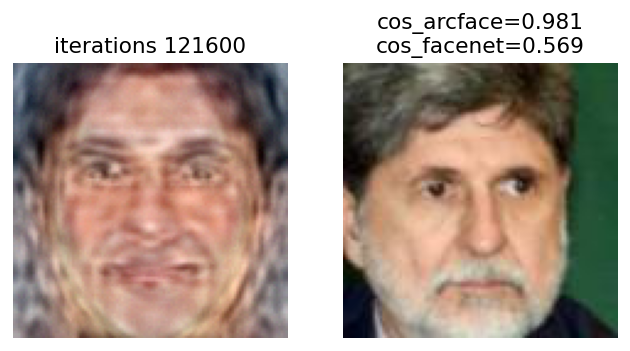

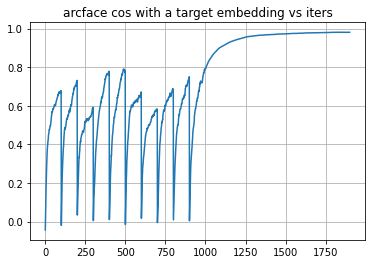

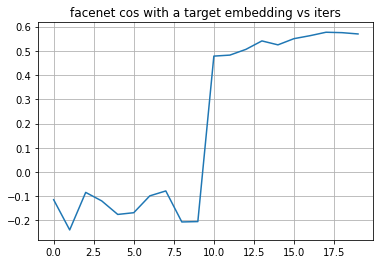

KeyboardInterrupt: ignored

In [20]:
with torch.no_grad():
    for _ in range(2001):
        start = time()
        if pipeline.iters >= pipeline.N_restarts * pipeline.iters_before_restart:
            pipeline.lr = 0.001
        recovered_face, cos_target = pipeline()
        cosines_target.append(cos_target)
        time_per_iter = round(time() - start,2)
        
        print(f"time={time_per_iter}    queries={iters*pipeline.batch_size}   cos_target={round(cos_target,3)}    \
        norm={round(pipeline.norm,4)}", end="\r")
        
        if iters % 100 == 0:
            clear_output(wait=True)
            face = np.transpose(recovered_face.cpu().detach().numpy(),(1,2,0))
            face = face - np.min(face)
            face = face / np.max(face)
            facenet_sims.append(get_sim(DEVICE,path1=IMAGE, im2=face))

            plt.figure(dpi=130)
            plt.subplot(1,2,1)
            plt.axis("off")
            plt.title(f"iterations {iters*pipeline.batch_size}")
            plt.imshow(face)
            plt.subplot(1,2,2)
            plt.axis("off")
            plt.title(f"cos_arcface={round(cos_target,3)}\ncos_facenet={round(facenet_sims[-1],3)}")
            plt.imshow(np.array(Image.open(IMAGE)))
            plt.show()

            plt.plot(cosines_target)
            plt.grid()
            plt.title("arcface cos with a target embedding vs iters")
            plt.show()
            
            plt.plot(facenet_sims)
            plt.grid()
            plt.title("facenet cos with a target embedding vs iters")
            plt.show()
            
        iters += 1